In [1]:
# 读入数据
import pandas as pd
import numpy as np

train = pd.read_csv('data/kaggle-house/train.csv')
test = pd.read_csv('data/kaggle-house/test.csv')
all_X = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                  test.loc[:, 'MSSubClass':'SaleCondition']))

In [2]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train.shape

(1460, 81)

In [4]:
test.shape

(1459, 80)

In [7]:
# 预处理数据
numeric_feats = all_X.dtypes[all_X.dtypes != 'object'].index
# print(numeric_feats)
all_X[numeric_feats] = all_X[numeric_feats].apply(lambda x: (x-x.mean()) / (x.std()))

In [12]:
all_X2 = pd.get_dummies(all_X, dummy_na=True)
# all_X2.head()

In [15]:
all_X3 = all_X2.fillna(all_X2.mean())
# all_X3.head()

In [16]:
num_train = train.shape[0]

X_train = all_X3[:num_train].as_matrix()
X_test = all_X3[num_train:].as_matrix()
y_train = train.SalePrice.as_matrix()

In [19]:
# 导入NDArray格式数据
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon

X_train = nd.array(X_train)
y_train = nd.array(y_train)
y_train.reshape((num_train, 1))

X_test = nd.array(X_test)

In [20]:
square_loss = gluon.loss.L2Loss()

In [22]:
def get_rmse_log(net, X_train, y_train):
    # TODO: verify here
    num_train = X_train.shape[0]
    clipped_preds = nd.clip(net(X_train), 1, float('inf'))
    return np.sqrt(2*nd.sum(square_loss(nd.log(clipped_preds), nd.log(y_train))).asscalar() / num_train)

In [28]:
# 定义模型
def get_net():
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    net.initialize()
    return net

In [29]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

def train(net, X_train, y_train, X_test, y_test, epochs, verbose_epoch,
         learning_rate, weight_decay):
    train_loss = []
    if X_test is not None:
        test_loss = []
    batch_size = 100
    dataset_train = gluon.data.ArrayDataset(X_train, y_train)
    data_iter_train = gluon.data.DataLoader(dataset_train, batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate,'wd':weight_decay
    })
    net.collect_params().initialize(force_reinit=True)
    for epoch in range(epochs):
        for data, label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)
            
            cur_train_loss = get_rmse_log(net, X_train, y_train)
        if epoch > verbose_epoch:
            print("Epoch %d, train loss: %f" % (epoch, cur_train_loss))
        train_loss.append(cur_train_loss)
        if X_test is not None:
            cur_test_loss = get_rmse_log(net, X_test, y_test)
            test_loss.append(cur_test_loss)
    plt.plot(train_loss)
    plt.legend(['train'])
    if X_test is not None:
        plt.plot(test_loss)
        plt.legend(['train', 'test'])
    plt.show()
    if X_test is not None:
        return cur_train_loss, cur_test_loss
    else:
        return cur_train_loss

In [30]:
# K折交叉验证
def k_fold_cross_valid(k, epochs, verbose_epoch, X_train, y_train,
                      learning_rate, weight_decay):
    assert k>1
    fold_size = X_train.shape[0] // k
    train_loss_sum = 0.0
    test_loss_sum = 0.0
    for test_i in range(k):
        X_val_test = X_train[test_i * fold_size: (test_i + 1) * fold_size, :]
        y_val_test = y_train[test_i * fold_size: (test_i + 1) * fold_size]
        
        val_train_defined = False
        for i in range(k):
            if i != test_i:
                X_cur_fold = X_train[i*fold_size: (i+1)*fold_size, :]
                y_cur_fold = y_train[i*fold_size: (i+1)*fold_size]
                if not val_train_defined:
                    X_val_train = X_cur_fold
                    y_val_train = y_cur_fold
                    val_train_defined = True
                else:
                    # why concat? To stack k-2 training set (1 test, 1 val)
                    X_val_train = nd.concat(X_val_train, X_cur_fold, dim=0)
                    y_val_train = nd.concat(y_val_train, y_cur_fold, dim=0)
        net = get_net()
        train_loss, test_loss = train(net, X_val_train, y_val_train,
                                     X_val_test, y_val_test,
                                     epochs, verbose_epoch, learning_rate,
                                     weight_decay)
        train_loss_sum += train_loss
        print('Test loss: %f' % test_loss)
        test_loss_sum += test_loss
    return train_loss_sum / k, test_loss_sum / k

In [31]:
# 训练模型并交叉验证
k = 5
epochs = 100
verbose_epoch = 95
learning_rate = 5
weight_decay = 0.0

Epoch 96, train loss: 0.202218
Epoch 97, train loss: 0.200091
Epoch 98, train loss: 0.198108
Epoch 99, train loss: 0.196207


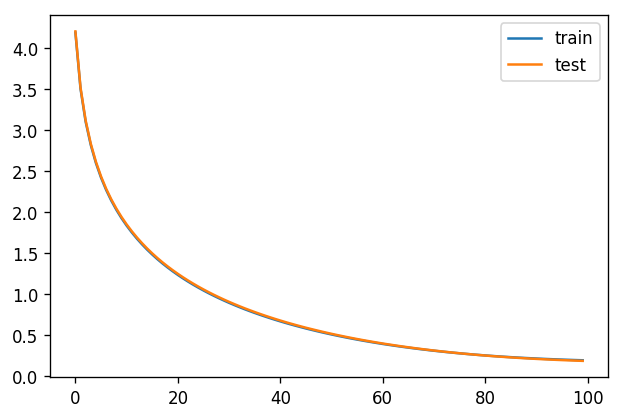

Test loss: 0.189132
Epoch 96, train loss: 0.197818
Epoch 97, train loss: 0.195647
Epoch 98, train loss: 0.193637
Epoch 99, train loss: 0.191675


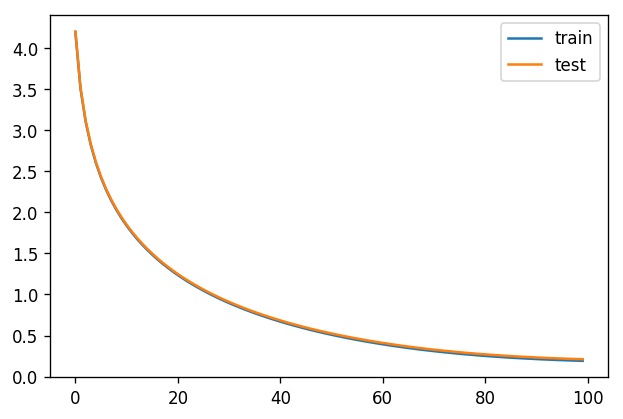

Test loss: 0.211376
Epoch 96, train loss: 0.199255
Epoch 97, train loss: 0.197124
Epoch 98, train loss: 0.195100
Epoch 99, train loss: 0.193217


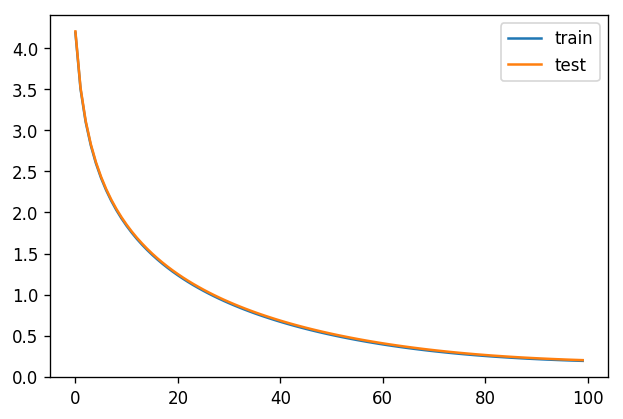

Test loss: 0.201955
Epoch 96, train loss: 0.201678
Epoch 97, train loss: 0.199541
Epoch 98, train loss: 0.197477
Epoch 99, train loss: 0.195524


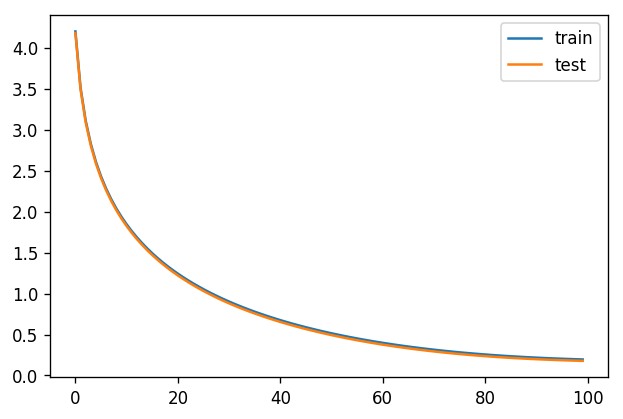

Test loss: 0.178443
Epoch 96, train loss: 0.196793
Epoch 97, train loss: 0.194556
Epoch 98, train loss: 0.192435
Epoch 99, train loss: 0.190425


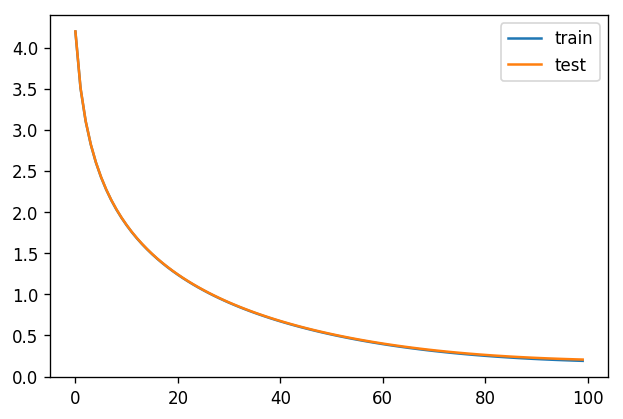

Test loss: 0.206324
5-fold validation: Avg train loss: 0.193410, Avg test loss: 0.197446


In [32]:
train_loss, test_loss = k_fold_cross_valid(k, epochs, verbose_epoch,
                                          X_train, y_train,
                                          learning_rate, weight_decay)
print('%d-fold validation: Avg train loss: %f, Avg test loss: %f' %
     (k, train_loss, test_loss))

In [35]:
# 预测并在Kaggle提交预测结果（选学）
# 定义预测函数
def learn(epochs, verbose_epoch, X_train, y_train, test,
          learning_rate, weight_decay):
    net = get_net()
    train(net, X_train, y_train, None, None, epochs, verbose_epoch,
         learning_rate, weight_decay)
    preds = net(X_test).asnumpy()
    test['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test['Id'], test['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

Epoch 96, train loss: 0.171137
Epoch 97, train loss: 0.170542
Epoch 98, train loss: 0.169996
Epoch 99, train loss: 0.169503


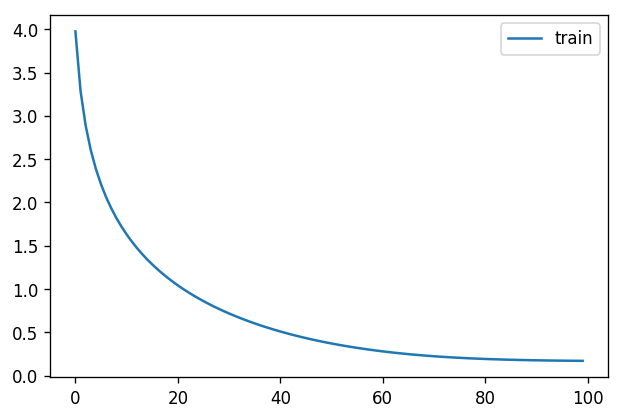

In [36]:
learn(epochs, verbose_epoch, X_train, y_train, test,
      learning_rate, weight_decay)